## importamos todo

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## DATOS

In [48]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [49]:
df_comp['market_value']=df_comp.ftse

In [50]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## para comparar modelos: LLR Test

In [51]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [52]:
import warnings
warnings.filterwarnings("ignore")

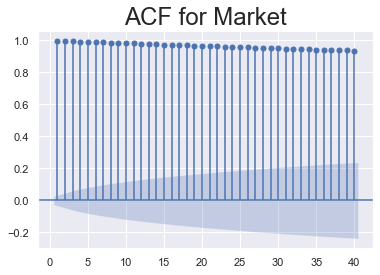

In [53]:
sgt.plot_acf(df.market_value, zero = False, lags = 40) # empezamos a partir del 1, no hacemos la correlacion en el periodo 1
plt.title("ACF for Market", size=24)
plt.show()

# esto no vale de nada para identificar un modelo MA

## creamos los retornos - asi tenemos una serie estacionaria ... precios no lo es

In [54]:
df['returns'] = df.market_value.pct_change(1)*100 # 1 indica pct change sobre 1 periodo

In [55]:
df.head() # ojo al NaN se pierde informacion

#y se debe considerar eso al ejecutar funciones como adfuller

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


In [56]:
import statsmodels.tsa.stattools as sts 
sts.adfuller(df.returns[1:])


(-12.770265719497296,
 7.798058336036148e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.767245697501)

## ACF for Returns

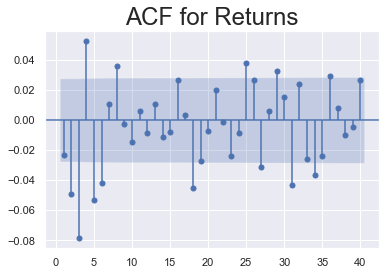

In [57]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40) # empezamos a partir del 1, no hacemos la correlacion en el periodo 1
plt.title("ACF for Returns", size=24)
plt.show()

# es muy diferente al acf para precios
# no todls son positivos ni signitficativos (como para precios)
# los valores varian mucho.
# los primeros retrasos son relevantes, pero sus coeficientes son negativos, i.e. valores consecutivos se mueven en direcciones contrarias
# mas o menos llega a 6 dias - una semana

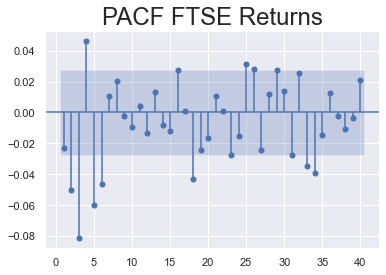

In [58]:
sgt.plot_pacf(df.returns[1:], lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

# para MA ser mira el ACF no PACF

# muy parecido al anterior
# los precios de un dia van en la direccion contraria a los de ayer 
# alretroceder mas menos relevantes son los valores - la mayoria de los efectos aarecen en la primera semana
# usaremos los retornos para MA

## MA(1) para tornos de FTSE

In [59]:
model_ret_ma_1 = ARMA(df.returns[1:], order=(0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
results_ret_ma_1.summary()

# con un nivel de confianza al 5% el coeficiente no es significativo. Si el nivel es 10% si seria significativo

# si no es significativo no podemos considerar el modelo.
# viendo ACF el primer coeficiente esta en el area azulcon lo que es normal que no sea significativo
# hasta el 8a mas o menos son significativos - y se puede considerar hasta ese coeficiente. Se pueden ignorar el resto
# kuego AIC/BIC dira si merece la pena llegar hasta esa complejidad

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Sat, 08 Apr 2023   AIC                          15865.190
Time:                        16:10:39   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8550           +0.0000j           38.8550            0.0000
-----------------------------------------------------------------------------
"""

  ### MA de mayores retrasos
  
  Otra politica es hacer una busqueda exhaustiva y elegir los mejores - comprobando siempre que sus valores son significativos
  
  ACF nos indica hasta que valor considerar (para MA, para AR seria PACF)
  
  Esta aproximacion vale igual para AR y para MA y ARMA ... e incluso ARIMA....
  
  Viendo ACF hasta 8 retornos son significativos

In [83]:
model_ma_2 = ARMA(df.returns[1:], order=(0,2))
results_ma_2 = model_ma_2.fit()
model_ma_3 = ARMA(df.returns[1:], order=(0,3))
results_ma_3 = model_ma_3.fit()
model_ma_4 = ARMA(df.returns[1:], order=(0,4))
results_ma_4 = model_ma_4.fit()
model_ma_5 = ARMA(df.returns[1:], order=(0,5))
results_ma_5 = model_ma_5.fit()
model_ma_6 = ARMA(df.returns[1:], order=(0,6))
results_ma_6 = model_ma_6.fit()
model_ma_7 = ARMA(df.returns[1:], order=(0,7))
results_ma_7 = model_ma_6.fit()
model_ma_8 = ARMA(df.returns[1:], order=(0,8))
results_ma_8 = model_ma_8.fit()

In [84]:
print("MA(2):  \t LL = ", results_ma_2.llf, "\t AIC = ", results_ma_2.aic)
print("MA(3):  \t LL = ", results_ma_3.llf, "\t AIC = ", results_ma_3.aic)
print("MA(4):  \t LL = ", results_ma_4.llf, "\t AIC = ", results_ma_4.aic)
print("MA(5):  \t LL = ", results_ma_5.llf, "\t AIC = ", results_ma_5.aic)
print("MA(6):  \t LL = ", results_ma_6.llf, "\t AIC = ", results_ma_6.aic)
print("MA(7):  \t LL = ", results_ma_7.llf, "\t AIC = ", results_ma_7.aic)
print("MA(8):  \t LL = ", results_ma_8.llf, "\t AIC = ", results_ma_8.aic)

MA(2):  	 LL =  -7922.863847484562 	 AIC =  15853.727694969124
MA(3):  	 LL =  -7904.317131139394 	 AIC =  15818.634262278789
MA(4):  	 LL =  -7898.773352243194 	 AIC =  15809.546704486387
MA(5):  	 LL =  -7892.82271440411 	 AIC =  15799.64542880822
MA(6):  	 LL =  -7889.221009891559 	 AIC =  15794.442019783119
MA(7):  	 LL =  -7889.221009891559 	 AIC =  15794.442019783119
MA(8):  	 LL =  -7885.60251045483 	 AIC =  15791.20502090966


In [85]:
print("\nLLR test p-value = " + str(LLR_test(results_ret_ma_1, results_ma_2)))

print("\nLLR test p-value = " + str(LLR_test(results_ma_2, results_ma_3)))
print("\nLLR test p-value = " + str(LLR_test(results_ma_3, results_ma_4)))
print("\nLLR test p-value = " + str(LLR_test(results_ma_4, results_ma_5)))
print("\nLLR test p-value = " + str(LLR_test(results_ma_6, results_ma_7)))
print("\nLLR test p-value = " + str(LLR_test(results_ma_7, results_ma_8)))

  


LLR test p-value = 0.0

LLR test p-value = 0.0

LLR test p-value = 0.001

LLR test p-value = 0.001

LLR test p-value = 1.0

LLR test p-value = 0.007


In [86]:
LLR_test(results_ma_6, results_ma_8, DF = 2)

#el 8 mejora al 6 asique el mejor seria el 8 - merece la pena la complejidad (aunque el 7 sale no significativo)
# ojo DF=2

# el ACF a partir del 8 ya no es significativo asi que no merece la pena explorarlo incluso por los que salen porque ya estan 
# muy retrasados
# hasta el 18 son nosifnificativos -agregarlos no lo mejoraria

0.027

In [87]:
results_ma_8.summary() #asegurarse que es estadisticmaente significativo las Ls... nos quedamos con el 8

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Sat, 08 Apr 2023   AIC                          15791.205
Time:                        16:17:36   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.returns    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.returns     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.returns    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.returns    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.returns     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.returns     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

## RESIDUOS DE RETORNOS

In [88]:
# usamos el modleo de orden 8
# hay que ver si los residuos se asemejan a ruido blanco

df['res_ret_ma_8'] = results_ma_8.resid[1:]

In [89]:
# calculamos la media y la varianza de los residuos

print("The mean of the residuals is " + str(df.res_ret_ma_8.mean()) + "\nThe variance of the residuals is " + str(round(df.res_ret_ma_8.var(),3)))

The mean of the residuals is -2.2185056655314858e-05
The variance of the residuals is 1.356


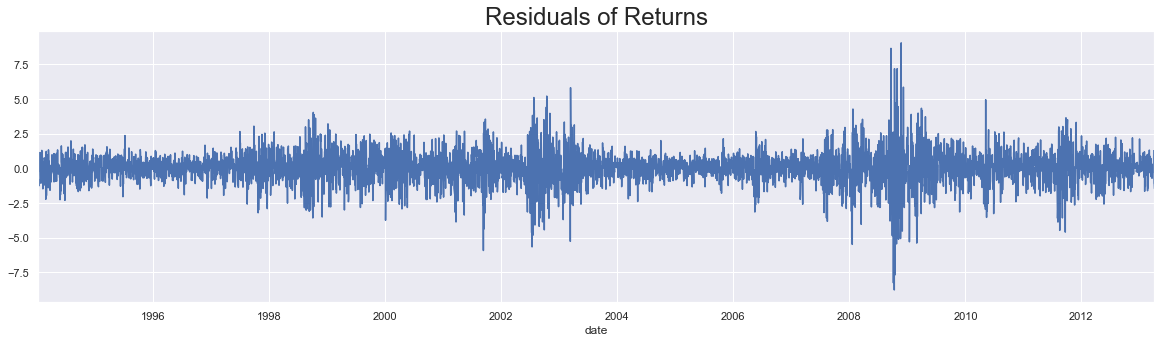

In [90]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

# si se excluye 2000 y 2008 - si es ruido blanco - miramos la estacionariedad

In [92]:
sts.adfuller(df.res_ret_ma_8[2:])

# son estacionarios
# no significa que sea ruido blanco

(-70.83581760847257,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.05218481707)

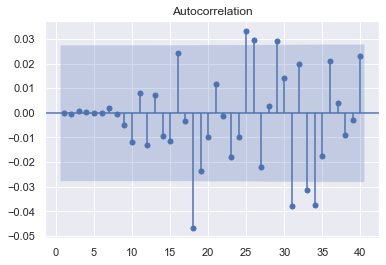

In [93]:
# el rtuido blanco, los coeficientes deberian ser no significativos ya que no tiene autocorrelacion
# la mayoria no son significativos (ninguno de los primeros 17)
#los valores son tan pequeños y tan bajos que nos confirman que si es ruido blanco
# los valores muy lejanos en el pasado pierden relevancia

sgt.plot_acf(df.res_ret_ma_8[2:], zero = False, lags = 40)
plt.show()

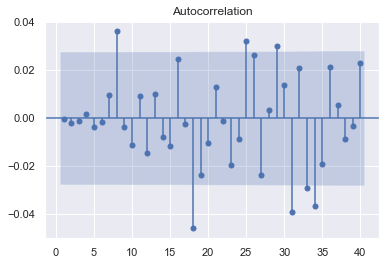

In [95]:
# Si hubiesemos considerado el modelo de solo 6 MA, 
# ya no se podria considerar tan claramente ruido blanco

df['res_ret_ma_6'] = results_ma_6.resid[1:]

sgt.plot_acf(df.res_ret_ma_6[2:], zero = False, lags = 40)
plt.show()

## Normalizacion de Precios

In [70]:
benchmark = df.market_value.iloc[0]
# el punto de referencia es el 0. Se podria usar cualquier punto de referencia (por ejemplo el maximo)
#en precios se suele usar la primera

df['norm'] = df.market_value.div(benchmark).mul(100)

In [71]:
df.head(5)

,market_value,returns,res_ret_ma_8,norm
date,,,,
1994-01-07,3445.98,NaN,NaN,100.000000
1994-01-10,3440.58,-0.156704,-93.671147,99.843296
1994-01-11,3413.77,-0.779229,-183.672017,99.065288
1994-01-12,3372.02,-1.222988,-158.015917,97.853731
1994-01-13,3360.01,-0.356166,-80.850404,97.505209


In [72]:
sts.adfuller(df['norm'])

# sigue sin ser estacionaria
# la normalizacion no afecta a la estacionariedad de la serie

# AR no se podria usar al no ser estacionario - se puede usar pero tendriamos contradicciones respecto las p de L(i)

(-1.9041551418836233,
 0.3301089327703129,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 19541.17381480549)

## Retornos Normalizados

Es muy normal normalizar retornos ya que en el caso de bolsa permite comparar la rentabilidad relativa.
Normalizacion nos da mediciones mas confiables para tomar decisiones. Desde el punto de vista estacionario es lo mismo, pero puede ser mas facil interpretarlo (sobre todo series economicas)

Lo que calculamos para no normalizaco valdria igual, el modelo de dimension 8, el proceso daria el mismo resultado.

In [73]:
bench_ret = df.returns.iloc[1] # el 0 no existe ES LA REFERENCIA PARA LA NORMALIZACION
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

In [74]:
df.head()

,market_value,returns,res_ret_ma_8,norm,norm_ret
date,,,,,
1994-01-07,3445.98,NaN,NaN,100.000000,NaN
1994-01-10,3440.58,-0.156704,-93.671147,99.843296,100.000000
1994-01-11,3413.77,-0.779229,-183.672017,99.065288,497.260711
1994-01-12,3372.02,-1.222988,-158.015917,97.853731,780.443046
1994-01-13,3360.01,-0.356166,-80.850404,97.505209,227.285567


In [75]:
sts.adfuller(df.norm_ret[1:])

#la serie si es estacionaria - como era ya para los retornos. La normalizacion no afecta tampoco cuando la serie es estacionaria

(-12.770265719497235,
 7.79805833603833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

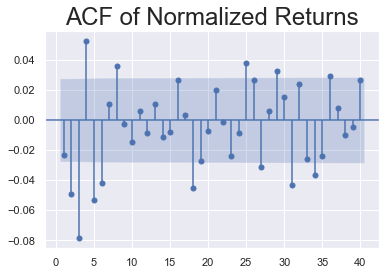

In [76]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns",size=24)
plt.show()

# ACF es igual a los reotrnos no normalizados 6 u 8 es lo que recomienda

In [77]:
model_norm_ret_ma_8 = ARMA(df.norm_ret[1:], order=(0,8))
# modelo de orden 8 con retornos nomralizados
# los resultados son los mismos que los ma(8) con retornos sinnormalizar
#la normalizacion no afecta a la seleccion del modelo (ni la estacionariedad, ni a los residuos)

results_norm_ret_ma_8 = model_norm_ret_ma_8.fit()
results_norm_ret_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood              -40307.597
Method:                       css-mle   S.D. of innovations            742.822
Date:                Sat, 08 Apr 2023   AIC                          80635.194
Time:                        16:14:29   BIC                          80700.406
Sample:                    01-10-1994   HQIC                         80658.045
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.846     -1.354      0.176     -29.311       5.364
ma.L1.norm_ret    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.norm_ret    -0.0495      0.014     -3.514      0.000      -0.077      -0.022
ma.L3.norm_ret    -0.0847      0.014     -5.993      0.000      -0.112      -0.057
ma.L4.norm_ret     0.0488      0.014      3.440      0.001       0.021       0.077
ma.L5.norm_ret    -0.0518      0.014     -3.634      0.000      -0.080      -0.024
ma.L6.norm_ret    -0.0402      0.014     -2.787      0.005      -0.068      -0.012
ma.L7.norm_ret     0.0084      0.014      0.587      0.557      -0.020       0.036
ma.L8.norm_ret     0.0366      0.014      2.626      0.009       0.009       0.064
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.4716           -0.4282j            1.5326           -0.0451
MA.2            1.4716           +0.4282j            1.5326            0.0451
MA.3            0.5944           -1.3169j            1.4448           -0.1825
MA.4            0.5944           +1.3169j            1.4448            0.1825
MA.5           -0.7318           -1.2736j            1.4689           -0.3330
MA.6           -0.7318           +1.2736j            1.4689            0.3330
MA.7           -1.4485           -0.6983j            1.6081           -0.4285
MA.8           -1.4485           +0.6983j            1.6081            0.4285
-----------------------------------------------------------------------------
"""

In [78]:
df['res_norm_ret_ma_8'] = results_norm_ret_ma_8.resid[1:]

In [79]:
sts.adfuller(df.res_norm_ret_ma_8[2:])

#los residuos son estacionarios

(-70.83586149217982,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 80088.858968148)

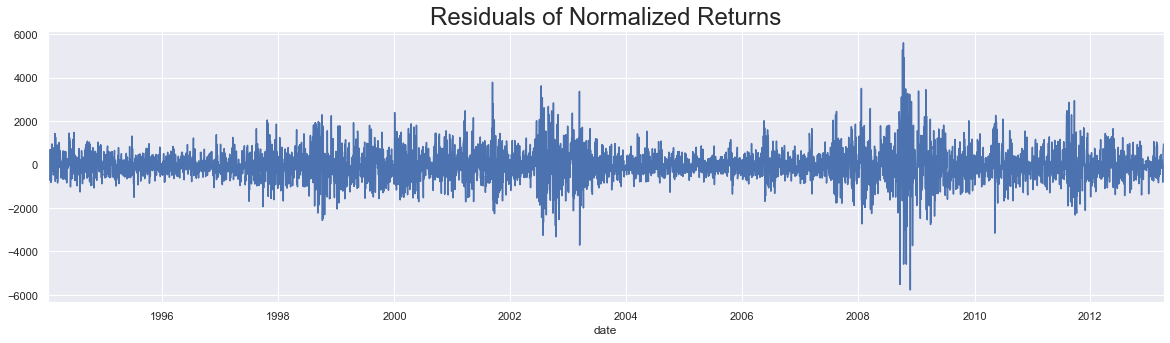

In [80]:
df.res_norm_ret_ma_8[1:].plot(figsize=(20,5))
plt.title("Residuals of Normalized Returns",size=24)
plt.show()
# la grafica sugiere estacionariedad - ruido blanco

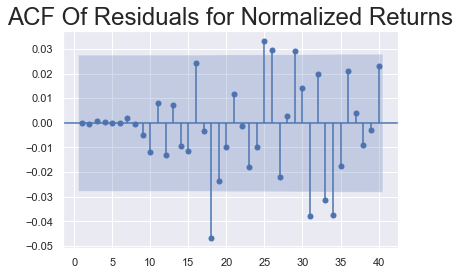

In [81]:
sgt.plot_acf(df.res_norm_ret_ma_8[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Normalized Returns",size=24)
plt.show()

# esto tambien indica ruido blanco - la eleccion del modelo es correcta

## MA Models For Prices

Vamos a probar MA para series que sabemos no estacionarias para ver que problemas podemos encontrar


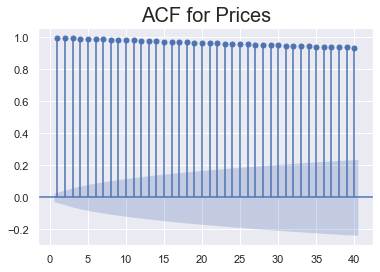

In [53]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF for Prices", size=20)
plt.show()

#la autocorrelacion es miuy alta como es tipico - esto significa que cuanto mas grande sea el orden seria mejor el resultado 
#al ser todos los retrasos relevantes
# Y donde parar??? pues en series noestacionarias que se construyan con MA no se sabe ... se deberia usar otro medodo o estacionalizarlo
